# 1.神经网络的底层搭建

这里，我们要实现一个拥有卷积层（CONV）和池化层（POOL）的网络，它包含了前向和反向传播，我们来定义一下符号：

* 上标$[l]$是指第$l$层

    * 比如：$a^{[4]}$是指第4层的激活值。$W^{[5]}$和$b^{[5]}$是指第5层的参数。
    

* 上标$（i）$是指来自第$i$个样本
    * 比如：$x^{(i)}$是指来自输入的第$i$个样本
    
    
* 下标$i$是指向量的第$i$项
    * 比如：$a_i^{[l]}$是指来自第$l$层的第$i$个激活值，假设这是一个完全连接层（FC）
    
    
* $n_H、n_W$与$n_c$是指分别表示给顶层的图像的高度、宽度和通道数，如果你想特指某一层，那么可以这样写：$n_H^{[l]}、n_W^{[l]}$与$n_c^{[l]}$


* $n_{H_{prev}}、n_{W_{prev}}、n_{C_{prev}}$分别表示前一层的图像的高度、宽度和通道数，如果你想制定特定层$l$,那么你也可以这样写：
$n_H^{[l-1]}、n_W^{[l-1]}、n_C^{[l-1]}$

## 1.1 - 导入库

我们先要导入一些库：

In [35]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#ipython很好用，但是如果在ipython里已经import过的模块修改后需要重新reload就需要这样
#在执行用户代码前，重新装入软件的扩展和模块。
%load_ext autoreload   
#autoreload 2：装入所有 %aimport 不包含的模块。
%autoreload 2          

np.random.seed(1)      #指定随机种子

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.2 - 大纲

我们将实现一个卷积神经网络的一些模块，下面我们将列举我们要实现的模块的函数功能：

* 卷积模块，包含以下函数：
    * 使用0扩充边界
    * 卷积窗口
    * 前向卷积
    * 反向卷积（可选）
    
* 池化模块，包含以下函数：
    * 前向池化
    * 创建掩码
    * 值分配
    * 反向池化（可选）
    
我们将在这里从底层搭建一个完整的模块，之后我们会用TensorFlow实现，模型结构如下：
![2018042521470222.png](https://github.com/LiAnGGGGGG/Machine-Learning-Note/blob/master/%E5%9B%BE%E7%89%87/8-%E7%BB%93%E6%9E%841.png?raw=true)

需要注意的是我们在前向传播的过程中，我们会存储一些值，以便在反向传播的过程中计算梯度值。

## 1.3 - 卷积神经网络

尽管编程框架使卷积容易使用，但它们仍然是深度学习中最难理解的概念之一。卷积层将输入转换成不同纬度的输出，如下所示：
![2018042521470222.png](https://github.com/LiAnGGGGGG/Machine-Learning-Note/blob/master/%E5%9B%BE%E7%89%87/8-%E7%BB%93%E6%9E%842.png?raw=true)

我们将一步步构建卷积层，我们将首先实现两个辅助函数：一个用于零填充，另一个用于计算卷积。

### 1.3.1 - 边界填充

边界填充将会在图像边界周围添加值为0的像素点，如下图所示：
![20180425213940990.png](https://github.com/LiAnGGGGGG/Machine-Learning-Note/blob/master/%E5%9B%BE%E7%89%87/8-%E8%BE%B9%E7%95%8C1.png?raw=true)

使用0填充边界有以下好处：
* 卷积了上一层之后的CONV层，没有缩小高度和宽度，这对建立更深的网络非常重要，否则在更深层时，高度/宽度会缩小。一个重要的例子是“same”卷积，自重高度/宽度在卷积完一层之后会被完全保留。


* 它可以帮助我们在图像边界保留更多信息，在没有填充的情况下，卷积过程中图像边缘的极少数值会受到过滤器的影响从而导致信息丢失。


我们将实现一个边界填充函数，它会把所有的样本图像$X$都使用0进行填充，我们可以使用np.pad来快速填充，需要注意的是如果你想使用pad = 1填充数组a.shape = （5,5,5,5,5）的第二维，使用pad = 3填充第四维，使用pad = 0来填充剩下的部分，我们可以这么做：

In [36]:
def zero_pad(X,pad):
    """
    把数据集X的图像边界全部使用0来扩充Pad个宽度和高度
    
    参数：
    
        X - 图像数据集，维度为（样本数，图像高度，图像宽度，图像通道数）
        
        pad - 整数，每个图像在垂直和水平维度上的填充量
    
    返回：
        
        X_paded - 扩充后的图像数据集，维度为（样本数，图像高度+2*pad，图像宽度 + 2*pad，通道数）
    """
    X_paded  = np.pad(X,(
                        (0,0),       #样本数，不填充
                        (pad,pad),   #图像高度,你可以视为上面填充x个，下面填充y个(x,y)
                        (pad,pad),   #图像宽度,你可以视为左边填充x个，右边填充y个(x,y)
                        (0,0)),      #通道数，不填充
                        'constant', constant_values=0)      #连续一样的值填充

    return X_paded

我们来测试一下：


x.shape = (4, 3, 3, 2)
x_paded.shape = (4, 7, 7, 2)
x[1, 1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_paded[1, 1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


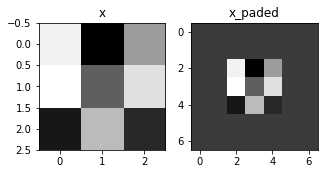

In [37]:
np.random.seed(1)
x = np.random.randn(4,3,3,2)
x_paded = zero_pad(x,2)
#查看信息
print ("x.shape =", x.shape)
print ("x_paded.shape =", x_paded.shape)
print ("x[1, 1] =", x[1, 1])
print ("x_paded[1, 1] =", x_paded[1, 1])

#绘制图
fig , axarr = plt.subplots(1,2)  #一行两列
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_paded')
axarr[1].imshow(x_paded[0,:,:,0])

### 1.3.2 - 单步卷积

在这里，我们要实现第一步卷积，我们要使用一个过滤器来卷积输入的数据。先来看看下面这个gif :
![20180425214517222.gif](https://github.com/LiAnGGGGGG/Machine-Learning-Note/blob/master/%E5%9B%BE%E7%89%87/8-%E5%8D%B7%E7%A7%AF1.gif?raw=true)

在计算机视觉应用中，左侧矩阵中的每个值都对应一个像素值，我们通过将其值与原始矩阵元素相乘，然后对它们进行求和来将3x3滤波器与图像进行卷积，我们需要实现一个函数，可以将一个3x3滤波器与单独的切片快进行卷积并输出一个实数。现在我们开始实现conv_single_step()

In [38]:
def conv_single_step(a_slice_prev,W,b):
    """
    在前一层的激活输出的一个片段上对应一个有参数W定义的过滤器。
    这里切片大小和过滤器大小相同
    
    参数：
        a_slice_prev - 输入数据的一个片段，维度为（过滤器大小，过滤器大小，上一通道数）
        w - 权重参数，包含在一个矩阵中，维度为（过滤器大小，过滤器大小，上一通道数）
        b - 偏置参数，包含在了一个矩阵中，维度为（1,1,1）
    
    返回：
        Z - 在输入数据的片X上卷积滑动窗口（W，b）的结果。
    """
    s = np.multiply(a_slice_prev,W) + b

    Z = np.sum(s)

    return Z
    

测试一下：

In [39]:
np.random.seed(1)

#这里切片大小和过滤器大小相同
a_slice_prev = np.random.randn(4,4,3)
W = np.random.randn(4,4,3)
b = np.random.randn(1,1,1)

Z = conv_single_step(a_slice_prev,W,b)

print("Z = " + str(Z))

Z = -23.16021220252078


### 1.3.3 - 卷积神经网络 - 前向传播

在前向传播的过程中，我们将使用多种过滤器对输入的数据进行卷积操作，每个过滤器会产生一个2D的矩阵，我们可以把它们堆叠起来，于是这些2D的卷积矩阵就变成了高维的矩阵。

我们需要实现一个函数以实现对激活值进行卷积，我们需要在激活值矩阵$A_{prev}$上使用过滤器$W$进行卷积，该函数的输入时前一层的激活输出$A_{prev}$,$F$个过滤器，其权重矩阵为$W$、偏置矩阵为$b$,每个过滤器只有一个偏置，最后，我们需要一个包含了步长$s$和填充$p$的字典的超参数。

小提示：

* 如果我要在矩阵A_prev(shape = (5,5,3))的左上角选择一个2x2的矩阵进行切片操作，那么可以这样做： 
a_slice_prev = a_prev[0:2,0:2,:] 

* 如果我想要自定义切片，我们可以这么做：先定义要切片的位置，vert_start、vert_end、horiz_start、horiz_end，它们的位置我们看一下下面的图就明白了。
![20180425214940264.png](https://github.com/LiAnGGGGGG/Machine-Learning-Note/blob/master/%E5%9B%BE%E7%89%87/8-%E5%89%8D%E5%90%911.png?raw=true)

我们还是说一下输出维度的计算公式吧：

$$n_H = \left \lfloor \frac{n_{Hprev}-f+2\times pad}{stride} \right \rfloor+1$$

$$n_W = \left \lfloor \frac{n_{Wprev}-f+2\times pad}{stride} \right \rfloor+1$$

$$n_C=过滤器数量$$

这里我们不会使用矢量化，知识用for循环来实现所有的东西

In [40]:
def conv_forward(A_prev, W, b, hparameters):
    """
    实现卷积函数的前向传播

    参数：
        A_prev - 上一层的激活输出矩阵，维度为(m, n_H_prev, n_W_prev, n_C_prev)，（样本数量，上一层图像的高度，上一层图像的宽度，上一层过滤器数量）
        W - 权重矩阵，维度为(f, f, n_C_prev, n_C)，（过滤器大小，过滤器大小，上一层的过滤器数量，这一层的过滤器数量）
        b - 偏置矩阵，维度为(1, 1, 1, n_C)，（1,1,1,这一层的过滤器数量）
        hparameters - 包含了"stride"与 "pad"的超参数字典。

    返回：
        Z - 卷积输出，维度为(m, n_H, n_W, n_C)，（样本数，图像的高度，图像的宽度，过滤器数量）
        cache - 缓存了一些反向传播函数conv_backward()需要的一些数据
    """

    #获取来自上一层数据的基本信息
    (m , n_H_prev , n_W_prev , n_C_prev) = A_prev.shape

    #获取权重矩阵的基本信息
    ( f , f ,n_C_prev , n_C ) = W.shape

    #获取超参数hparameters的值
    stride = hparameters["stride"]
    pad = hparameters["pad"]

    #计算卷积后的图像的宽度高度，参考上面的公式，使用int()来进行板除
    n_H = int(( n_H_prev - f + 2 * pad )/ stride) + 1
    n_W = int(( n_W_prev - f + 2 * pad )/ stride) + 1

    #使用0来初始化卷积输出Z
    Z = np.zeros((m,n_H,n_W,n_C))

    #通过A_prev创建填充过了的A_prev_pad
    A_prev_pad = zero_pad(A_prev,pad)

    for i in range(m):                              #遍历样本
        a_prev_pad = A_prev_pad[i]                  #选择第i个样本的扩充后的激活矩阵
        for h in range(n_H):                        #在输出的垂直轴上循环
            for w in range(n_W):                    #在输出的水平轴上循环
                for c in range(n_C):                #循环遍历输出的通道
                    #定位当前的切片位置
                    vert_start = h * stride         #竖向，开始的位置
                    vert_end = vert_start + f       #竖向，结束的位置
                    horiz_start = w * stride        #横向，开始的位置
                    horiz_end = horiz_start + f     #横向，结束的位置
                    #切片位置定位好了我们就把它取出来,需要注意的是我们是“穿透”取出来的，
                    #自行脑补一下吸管插入一层层的橡皮泥就明白了
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    #执行单步卷积
                    Z[i,h,w,c] = conv_single_step(a_slice_prev,W[: ,: ,: ,c],b[0,0,0,c])

    #数据处理完毕，验证数据格式是否正确
    assert(Z.shape == (m , n_H , n_W , n_C ))

    #存储一些缓存值，以便于反向传播使用
    cache = (A_prev,W,b,hparameters)

    return (Z , cache)

我们来测试一下：


In [41]:
np.random.seed(1)

A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)

hparameters = {"pad" : 2, "stride": 1}

Z , cache_conv = conv_forward(A_prev,W,b,hparameters)

print("np.mean(Z) = ", np.mean(Z))
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

np.mean(Z) =  0.15585932488906465
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


## 1.4 - 池化层

池化层会减少输入的宽度和高度，这样它会较少计算量的同时也使特征检测器对其输入中的位置更加稳定

* 最大值池化层：在输入矩阵中滑动一个大小为fx的窗口，选取窗口里的值中的最大值，然后作为输出的一部分。


* 均值池化层：在输入矩阵中滑动一个大小为fx的窗口，计算窗口里的值中的平均值，然后这个均值作为输出的一部分
![20180425215218806.png](https://github.com/LiAnGGGGGG/Machine-Learning-Note/blob/master/%E5%9B%BE%E7%89%87/8-%E6%B1%A0%E5%8C%961.png?raw=true)

池化层没有用于反向传播的参数，但是它们有像窗口的大小为f的超参数，它制定fxf窗口的高度和宽度，我们可以计算出最大值或平均值。

### 1.4.1 - 池化层的前向传播

现在我们要在同一个函数中实现最大值池化层和均值池化层，和之前计算输出维度一样，池化层的计算也是一样的。
$$n_H = \left \lfloor \frac{n_{Hprev}-f}{stride} \right \rfloor+1$$

$$n_W = \left \lfloor \frac{n_{Wprev}-f}{stride} \right \rfloor+1$$

$$n_C=n_{Cprev}$$

In [42]:
def pool_forward(A_prev,hparameters,mode="max"):
    """
    实现池化层的前向传播

    参数：
        A_prev - 输入数据，维度为(m, n_H_prev, n_W_prev, n_C_prev)
        hparameters - 包含了 "f" 和 "stride"的超参数字典
        mode - 模式选择【"max" | "average"】

    返回：
        A - 池化层的输出，维度为 (m, n_H, n_W, n_C)
        cache - 存储了一些反向传播需要用到的值，包含了输入和超参数的字典。
    """

    #获取输入数据的基本信息
    (m , n_H_prev , n_W_prev , n_C_prev) = A_prev.shape

    #获取超参数的信息
    f = hparameters["f"]
    stride = hparameters["stride"]

    #计算输出维度
    n_H = int((n_H_prev - f) / stride ) + 1
    n_W = int((n_W_prev - f) / stride ) + 1
    n_C = n_C_prev

    #初始化输出矩阵
    A = np.zeros((m , n_H , n_W , n_C))

    for i in range(m):                              #遍历样本
        for h in range(n_H):                        #在输出的垂直轴上循环
            for w in range(n_W):                    #在输出的水平轴上循环
                for c in range(n_C):                #循环遍历输出的通道
                    #定位当前的切片位置
                    vert_start = h * stride         #竖向，开始的位置
                    vert_end = vert_start + f       #竖向，结束的位置
                    horiz_start = w * stride        #横向，开始的位置
                    horiz_end = horiz_start + f     #横向，结束的位置
                    #定位完毕，开始切割
                    a_slice_prev = A_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]

                    #对切片进行池化操作
                    if mode == "max":
                        A[ i , h , w , c ] = np.max(a_slice_prev)
                    elif mode == "average":
                        A[ i , h , w , c ] = np.mean(a_slice_prev)

    #池化完毕，校验数据格式
    assert(A.shape == (m , n_H , n_W , n_C))

    #校验完毕，开始存储用于反向传播的值
    cache = (A_prev,hparameters)

    return A,cache

我们来测试一下：

In [43]:
np.random.seed(1)
A_prev = np.random.randn(2,4,4,3)
hparameters = {"f":4 , "stride":1}

A , cache = pool_forward(A_prev,hparameters,mode="max")
A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print("----------------------------")
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
A = [[[[1.74481176 1.6924546  2.10025514]]]


 [[[1.19891788 1.51981682 2.18557541]]]]
----------------------------
mode = average
A = [[[[-0.09498456  0.11180064 -0.14263511]]]


 [[[-0.09525108  0.28325018  0.33035185]]]]


## 1.5 - 卷积神经网络中的反向传播（选学）

在现在的深度学习框架中，你只需要实现前向传播，框架负责后向传播，所以大多数深度学习工程师不需要费心处理后向传播的细节，卷积网络的后向传播是有点复杂的，但是如果你愿意，你可以选择性来学习本节

在前面的课程中，我们已经实现了一个简单的（全连接）神经网络，我们使用反向传播来计算关于更新参数的成本梯度，类似的，在卷积神经网络中我们可以计算出关于成本的导数来更新参数，反向传播的方程并不简单，吴恩达老师并没有在课堂上推导它们，单我们可以在下面简要介绍。

### 1.5.1 - 卷积层的反向传播

我们来看一下如何实现卷积层的反向传播

### 1.5.1.1 - 计算dA

下面的公式是计算$dA$的：
$$dA+=\sum_{h=0}^{n_H}\sum_{w=0}^{n_W}W_c\times dZ_{hw}$$

其中，$W_c$是过滤器，$Z_{hw}$是一个标量，$Z_hw$是卷积层第$h$行第$w$列的使用点乘计算后的输出$Z$的梯度。需要注意的是在每次更新$dA$的时候，都会用相同的过滤器$W_c$乘以不同的$dZ$,因为在前向传播的时候，每个过滤器都与a_slice进行了点乘相加，所以在计算$dA$的时候，我们需要把a_slice的梯度也加进来，我们可以在循坏中加一句代码：
```
da_perv_pad[vert_start:vert_end,horiz_start:horiz_end,:] += W[:,:,:,c] * dZ[i,h,w,c]
```
### 1.5.1.2 - 计算dW

这是计算$dW_c$的公式（$dW_c$是一个过滤器的梯度）：
$$dW_c+=\sum_{h=0}^{n_H}\sum_{w=0}^{n_W}a_{slice}\times dZ_{hw}$$

其中$a_{slice}$对应着$Z_{ij}$的激活值。由此，我们就可以推导$W$的梯度，因为我们使用了过滤器来对数据进行窗口滑动，在这里，我们实际上是切出了和过滤器一样大小的切片，切了多少次就产生了多少个梯度，所以我们需要把它们加起来得到这个数据集的整体$dW$.

在代码上我们只需要使用一行代码实现：
```
dW[:,:,:, c] += a_slice * dZ[i , h , w , c]
```

### 1.5.1.3 - 计算db

这个是计算$db$的公式：
$$db=\sum_h\sum_w dZ_{hw}$$

和以前的神经网络一样，$db$是由$dZ$累加计算的，在这里，我们只需要将conv的输出Z的所有梯度累加就好了。在代码上我们只需要使用一行代码实现：
```
db[:,:,:,c] += dZ[ i, h, w, c]
```

### 1.5.1.4 - 函数实现

现在我们将实现反向传播函数conv_backward(),我们需要把所有的训练样本的过滤器、权值、高度、宽度都要加进来，然后使用公式1、2、3计算对应的梯度

In [44]:
def conv_backward(dZ,cache):
    """
    实现卷积层的反向传播

    参数：
        dZ - 卷积层的输出Z的 梯度，维度为(m, n_H, n_W, n_C)
        cache - 反向传播所需要的参数，conv_forward()的输出之一

    返回：
        dA_prev - 卷积层的输入（A_prev）的梯度值，维度为(m, n_H_prev, n_W_prev, n_C_prev)
        dW - 卷积层的权值的梯度，维度为(f,f,n_C_prev,n_C)
        db - 卷积层的偏置的梯度，维度为（1,1,1,n_C）

    """
    #获取cache的值
    (A_prev, W, b, hparameters) = cache

    #获取A_prev的基本信息
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    #获取dZ的基本信息
    (m,n_H,n_W,n_C) = dZ.shape

    #获取权值的基本信息
    (f, f, n_C_prev, n_C) = W.shape

    #获取hparaeters的值
    pad = hparameters["pad"]
    stride = hparameters["stride"]

    #初始化各个梯度的结构
    dA_prev = np.zeros((m,n_H_prev,n_W_prev,n_C_prev))
    dW = np.zeros((f,f,n_C_prev,n_C))
    db = np.zeros((1,1,1,n_C))

    #前向传播中我们使用了pad，反向传播也需要使用，这是为了保证数据结构一致
    A_prev_pad = zero_pad(A_prev,pad)
    dA_prev_pad = zero_pad(dA_prev,pad)

    #现在处理数据
    for i in range(m):
        #选择第i个扩充了的数据的样本,降了一维。
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]

        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    #定位切片位置
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f

                    #定位完毕，开始切片
                    a_slice = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]

                    #切片完毕，使用上面的公式计算梯度
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end,:] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i,h,w,c]
                    db[:,:,:,c] += dZ[i,h,w,c]
        #设置第i个样本最终的dA_prev,即把非填充的数据取出来。
        dA_prev[i,:,:,:] = da_prev_pad[pad:-pad, pad:-pad, :]

    #数据处理完毕，验证数据格式是否正确
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))

    return (dA_prev,dW,db)

测试一下：

In [45]:
np.random.seed(1)
#初始化参数
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2, "stride": 1}

#前向传播
Z , cache_conv = conv_forward(A_prev,W,b,hparameters)
#反向传播
dA , dW , db = conv_backward(Z,cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 9.608990675868995
dW_mean = 10.581741275547566
db_mean = 76.37106919563735


### 1.5.2 - 池化层的反向传播

接下来，我们从最大值池化层开始实现池化层的反向传播，即使池化层没有反向传播过程中要更新的参数，我们仍然要通过池化层反向传播梯度，以便在池化层之前的层（比如卷积层）计算梯度

### 1.5.2.1 - 最大值池化层的反向传播

在开始池化层的反向传播之前，我们需要创建一个create_mask_from_window()的函数，我们来看一下它是干什么的：

$$X=\begin{bmatrix}
1 &3 \\ 
4 & 2
\end{bmatrix}\rightarrow M=\begin{bmatrix}
0&0 \\ 
1 & 0
\end{bmatrix}$$

正如你所看到的，这个函数创建了一个掩码矩阵，以保存最大值的位置，当为1的时候表示最大值的位置，其他的为0，这个是最大值池化层，均值池化层的向后传播也和这个差不多，但是使用的是不同的掩码。

In [46]:
def create_mask_from_window(x):
    """
    从输入矩阵中创建掩码，以保存最大值的矩阵的位置。

    参数：
        x - 一个维度为(f,f)的矩阵

    返回：
        mask - 包含x的最大值的位置的矩阵
    """
    mask = x == np.max(x)

    return mask

测试一下：

In [47]:
np.random.seed(1)

x = np.random.randn(2,3)

mask = create_mask_from_window(x)

print("x = " + str(x)) 
print("mask = " + str(mask))

x = [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask = [[ True False False]
 [False False False]]


为什么我们要创建这一个掩码矩阵呢？想一下我们的正向传播首先是经过卷积层，然后滑动地取卷积层最大值构成了池化层，如果我们不记录最大值的位置，那么我们怎样才能反向传播到卷积层呢？



### 1.5.2.2 均值池化层的反向传播

  在最大值池化层中，对于每个输入窗口，输出的所有值都来自输入中的最大值，但是在均值池化层中，因为是计算均值，所以输入窗口的每个元素对输出有一样的影响，我们来看看如何反向传播吧
  
$$dZ = 1\rightarrow dZ = \begin{bmatrix}
\frac{1}{4}  &\frac{1}{4} \\ 
 \frac{1}{4}&\frac{1}{4} 
\end{bmatrix}$$

In [48]:
def distribute_value(dz,shape):
    """
    给定一个值，为按矩阵大小平均分配到每一个矩阵位置中。

    参数：
        dz - 输入的实数
        shape - 元组，两个值，分别为n_H , n_W

    返回：
        a - 已经分配好了值的矩阵，里面的值全部一样。

    """
    #获取矩阵的大小
    (n_H , n_W) = shape

    #计算平均值
    average = dz / (n_H * n_W)

    #填充入矩阵
    a = np.ones(shape) * average

    return a


测试一下：

In [49]:
dz = 2
shape = (2,2)

a = distribute_value(dz,shape)
print("a = " + str(a))

a = [[0.5 0.5]
 [0.5 0.5]]


### 1.5.2.3 - 池化层的反向传播

In [50]:
def pool_backward(dA,cache,mode = "max"):
    """
    实现池化层的反向传播

    参数:
        dA - 池化层的输出的梯度，和池化层的输出的维度一样
        cache - 池化层前向传播时所存储的参数。
        mode - 模式选择，【"max" | "average"】

    返回：
        dA_prev - 池化层的输入的梯度，和A_prev的维度相同

    """
    #获取cache中的值
    (A_prev , hparaeters) = cache

    #获取hparaeters的值
    f = hparaeters["f"]
    stride = hparaeters["stride"]

    #获取A_prev和dA的基本信息
    (m , n_H_prev , n_W_prev , n_C_prev) = A_prev.shape
    (m , n_H , n_W , n_C) = dA.shape

    #初始化输出的结构
    dA_prev = np.zeros_like(A_prev)

    #开始处理数据
    for i in range(m):
        a_prev = A_prev[i]      
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    #定位切片位置
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f

                    #选择反向传播的计算方式
                    if mode == "max":
                        #开始切片
                        a_prev_slice = a_prev[vert_start:vert_end,horiz_start:horiz_end,c]
                        #创建掩码
                        mask = create_mask_from_window(a_prev_slice)
                        #计算dA_prev
                        dA_prev[i,vert_start:vert_end,horiz_start:horiz_end,c] += np.multiply(mask,dA[i,h,w,c])

                    elif mode == "average":
                        #获取dA的值
                        da = dA[i,h,w,c]
                        #定义过滤器大小
                        shape = (f,f)
                        #平均分配
                        dA_prev[i,vert_start:vert_end, horiz_start:horiz_end ,c] += distribute_value(da,shape)
    #数据处理完毕，开始验证格式
    assert(dA_prev.shape == A_prev.shape)

    return dA_prev

测试一下：

In [51]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]


# 2. 神经网络的应用

我们应急使用了原生代码实现了卷积神经网络，现在我们要使用TensorFlow来实现，然后应用到手势识别中，在这里我们要实现4个函数，一起来看看吧

## 2.1.0 TensorFlow 模型

我们先来导入库：

In [55]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.python.framework import ops
import tf_utils
import time
import math
import cnn_utils
#%matplotlib inline #如果你使用的是jupyter notebook取消注释
np.random.seed(1)



我们使用的是【中文】【吴恩达课后编程作业】Course 2 - 改善深层神经网络 - 第三周作业 - TensorFlow入门的数据集 
![20180425220341697.png](https://github.com/LiAnGGGGGG/Machine-Learning-Note/blob/master/%E5%9B%BE%E7%89%87/8-%E9%97%AE%E9%A2%981.png?raw=true)

我们再来看一下里面有什么：

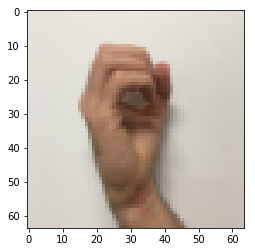

Y = 0


In [59]:
X_train_orig , Y_train_orig , X_test_orig , Y_test_orig , classes = tf_utils.load_dataset()
index =20

plt.imshow(X_train_orig[index])
plt.show()
print("Y = " + str(np.squeeze(Y_train_orig[:,index])))

在对TensorFlow的练习中，我们已经建立了一个神经网络，也是使用了这个数据集，我们再来看一下数据的维度。

In [60]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = cnn_utils.convert_to_one_hot(Y_train_orig, 6).T
Y_test = cnn_utils.convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


# 2.1.1 -  创建placeholders

TensorFlow要求为运行会话时将输入到模型中的输入数据创建占位符，现在我们要实现创建占位符的函数，因为我们使用的是小批量数据块，输入的样本数量可能不固定，所以我们在数量那里我们要使用None作为可变变量，输入X的维度为【None,n_H0,n_W0,n_C0】,对应的Y是【None,n_y】

In [61]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    为session创建占位符

    参数：
        n_H0 - 实数，输入图像的高度
        n_W0 - 实数，输入图像的宽度
        n_C0 - 实数，输入的通道数
        n_y  - 实数，分类数

    输出：
        X - 输入数据的占位符，维度为[None, n_H0, n_W0, n_C0]，类型为"float"
        Y - 输入数据的标签的占位符，维度为[None, n_y]，维度为"float"
    """
    X = tf.placeholder(tf.float32,[None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32,[None, n_y])

    return X,Y

测试一下：

In [63]:
X , Y = create_placeholders(64,64,3,6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(?, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)


# 2.1.2 -  初始化参数

现在我们将使用tf.contrib.layers.xavier_initializer(seed = 0)来初始化权值/过滤器$W1、W2$。在这里，我们不需要考虑偏置，因为TensorFlow会考虑到的，需要注意的是我们只需要初始化为2D卷积函数，全连接层TensorFlow会自动初始化的。

In [64]:
def initialize_parameters():
    """
    初始化权值矩阵，这里我们把权值矩阵硬编码：
    W1 : [4, 4, 3, 8]
    W2 : [2, 2, 8, 16]

    返回：
        包含了tensor类型的W1、W2的字典
    """
    tf.set_random_seed(1)

    W1 = tf.get_variable("W1",[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))

    parameters = {"W1": W1,
                  "W2": W2}

    return parameters


测试一下：

In [65]:
tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

    sess_test.close()

W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


# 2.1.2 - 前向传播

在TensorFlow里面有一些可以直接拿来用的函数：

* tf.nn.conv2d(X,W1,strides=[1,s,s,1],padding='SAME'):给定输入$X$和一组过滤器$W1$,这个函数将会自动使用$W1$来对$X$进行卷积，第三个输入参数是[1,s,s,1]是指对于输入 (m, n_H_prev, n_W_prev, n_C_prev)而言，每次滑动的步伐。


* tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME')：给定输入$X$,该函数将会使用大小为（f,f）以及步伐为(s,s)的窗口对其进行滑动取最大值

* tf.nn.relu(Z1)：计算Z1的ReLU激活


* tf.contrib.layers.flatten(P)：给定一个输入P，此函数将会把每个样本转化成一维的向量，然后返回一个tensor变量，其维度为（batch_size,k）.


* tf.contrib.layers.fully_connected(F, num_outputs)：给定一个已经一维化了的输入F，此函数将会返回一个由全连接层计算过后的输出。


使用tf.contrib.layers.fully_connected(F, num_outputs)的时候，全连接层会自动初始化权值且在你训练模型的时候它也会一直参与，所以当我们初始化参数的时候我们不需要专门去初始化它的权值。

我们实现前向传播的时候，我们需要定义一下我们模型的大概样子：

$$CONV2D\rightarrow RELU\rightarrow MAXPOOL\rightarrow CONV2D\rightarrow RELU\rightarrow MAXPOOL\rightarrow FULLCONNECTED$$

具体我们事先的时候，我们需要使用一下步骤和参数：

* Conv2d : 步伐：1，填充方式：“SAME”


* ReLU 


* Max pool : 过滤器大小：8x8，步伐：8x8，填充方式：“SAME”


* Conv2d : 步伐：1，填充方式：“SAME”


* ReLU 


* Max pool : 过滤器大小：4x4，步伐：4x4，填充方式：“SAME”


* 一维化上一层的输出


* 全连接层（FC）：使用没有非线性激活函数的全连接层。这里不要调用SoftMax， 这将导致输出层中有6个神经元，然后再传递到softmax。 在TensorFlow中，softmax和cost函数被集中到一个函数中，在计算成本时您将调用不同的函数。



In [66]:
def forward_propagation(X,parameters):
    """
    实现前向传播
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    参数：
        X - 输入数据的placeholder，维度为(输入节点数量，样本数量)
        parameters - 包含了“W1”和“W2”的python字典。

    返回：
        Z3 - 最后一个LINEAR节点的输出

    """
    W1 = parameters['W1']
    W2 = parameters['W2']

    #Conv2d : 步伐：1，填充方式：“SAME”
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding="SAME")
    #ReLU ：
    A1 = tf.nn.relu(Z1)
    #Max pool : 窗口大小：8x8，步伐：8x8，填充方式：“SAME”
    P1 = tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding="SAME")

    #Conv2d : 步伐：1，填充方式：“SAME”
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding="SAME")
    #ReLU ：
    A2 = tf.nn.relu(Z2)
    #Max pool : 过滤器大小：4x4，步伐：4x4，填充方式：“SAME”
    P2 = tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding="SAME")

    #一维化上一层的输出
    P = tf.contrib.layers.flatten(P2)

    #全连接层（FC）：使用没有非线性激活函数的全连接层
    Z3 = tf.contrib.layers.fully_connected(P,6,activation_fn=None)

    return Z3

测试一下：

In [67]:
tf.reset_default_graph()
np.random.seed(1)

with tf.Session() as sess_test:
    X,Y = create_placeholders(64,64,3,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)

    init = tf.global_variables_initializer()
    sess_test.run(init)

    a = sess_test.run(Z3,{X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))

    sess_test.close()

Z3 = [[ 1.4416984  -0.24909666  5.450499   -0.2618962  -0.20669907  1.3654671 ]
 [ 1.4070846  -0.02573211  5.08928    -0.48669922 -0.40940708  1.2624859 ]]


# 2.1.3 计算成本

我们要在这里实现计算成本的函数，下面的两个函数是我们要用到的：


* tf.nn.softmax_cross_entropy_with_logits(logits = Z3 , lables = Y)：计算softmax的损失函数。这个函数既计算softmax的激活，也计算其损失，你可以阅读手册


* tf.reduce_mean：计算的是平均值，使用它来计算所有样本的损失来得到总成本。你可以阅读手册


现在，我们就来实现计算成本的函数。


In [68]:
def compute_cost(Z3,Y):
    """
    计算成本
    参数：
        Z3 - 正向传播最后一个LINEAR节点的输出，维度为（6，样本数）。
        Y - 标签向量的placeholder，和Z3的维度相同

    返回：
        cost - 计算后的成本

    """

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))

    return cost

测试一下：

In [70]:
tf.reset_default_graph()

with tf.Session() as sess_test:
    np.random.seed(1)
    X,Y = create_placeholders(64,64,3,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)

    init = tf.global_variables_initializer()
    sess_test.run(init)
    a = sess_test.run(cost,{X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

    sess_test.close()

cost = 4.6648693


# 2.1.4 构建模型

最后，我们已经实现了我们所有的函数，我们现在就可以实现我们的模型了。

我们之前在课程2就实现过random_mini_batches()这个函数，它返回的是一个mini-batches的列表。

在实现这个模型的时候我们要经历以下步骤：


* 创建占位符


* 初始化参数


* 前向传播


* 计算成本


* 反向传播


* 创建优化器


最后，我们将创建一个session来运行模型。

In [71]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009, 
         num_epochs=100,minibatch_size=64,print_cost=True,isPlot=True):
    """
    使用TensorFlow实现三层的卷积神经网络
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    参数：
        X_train - 训练数据，维度为(None, 64, 64, 3)
        Y_train - 训练数据对应的标签，维度为(None, n_y = 6)
        X_test - 测试数据，维度为(None, 64, 64, 3)
        Y_test - 训练数据对应的标签，维度为(None, n_y = 6)
        learning_rate - 学习率
        num_epochs - 遍历整个数据集的次数
        minibatch_size - 每个小批量数据块的大小
        print_cost - 是否打印成本值，每遍历100次整个数据集打印一次
        isPlot - 是否绘制图谱

    返回：
        train_accuracy - 实数，训练集的准确度
        test_accuracy - 实数，测试集的准确度
        parameters - 学习后的参数
    """
    ops.reset_default_graph()  #能够重新运行模型而不覆盖tf变量
    tf.set_random_seed(1)    #确保你的数据和我一样
    seed = 3                 #指定numpy的随机种子
    (m , n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []

    #为当前维度创建占位符
    X , Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    #初始化参数
    parameters = initialize_parameters()

    #前向传播
    Z3 = forward_propagation(X,parameters)

    #计算成本
    cost = compute_cost(Z3,Y)

    #反向传播，由于框架已经实现了反向传播，我们只需要选择一个优化器就行了
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    #全局初始化所有变量
    init = tf.global_variables_initializer()

    #开始运行
    with tf.Session() as sess:
        #初始化参数
        sess.run(init)
        #开始遍历数据集
        for epoch in range(num_epochs):
            minibatch_cost = 0
            num_minibatches = int(m / minibatch_size) #获取数据块的数量
            seed = seed + 1
            minibatches = cnn_utils.random_mini_batches(X_train,Y_train,minibatch_size,seed) 

            #对每个数据块进行处理
            for minibatch in minibatches:
                #选择一个数据块
                (minibatch_X,minibatch_Y) = minibatch
                #最小化这个数据块的成本
                _ , temp_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X, Y:minibatch_Y})

                #累加数据块的成本值
                minibatch_cost += temp_cost / num_minibatches

            #是否打印成本
            if print_cost:
                #每5代打印一次
                if epoch % 5 == 0:
                    print("当前是第 " + str(epoch) + " 代，成本值为：" + str(minibatch_cost))

            #记录成本
            if epoch % 1 == 0:
                costs.append(minibatch_cost)

        #数据处理完毕，绘制成本曲线
        if isPlot:
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()

        #开始预测数据
        ## 计算当前的预测情况
        predict_op = tf.arg_max(Z3,1)
        corrent_prediction = tf.equal(predict_op , tf.arg_max(Y,1))

        ##计算准确度
        accuracy = tf.reduce_mean(tf.cast(corrent_prediction,"float"))
        print("corrent_prediction accuracy= " + str(accuracy))

        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuary = accuracy.eval({X: X_test, Y: Y_test})

        print("训练集准确度：" + str(train_accuracy))
        print("测试集准确度：" + str(test_accuary))

        return (train_accuracy,test_accuary,parameters)

当前是第 0 代，成本值为：1.9213323593139648
当前是第 5 代，成本值为：1.9041557535529137
当前是第 10 代，成本值为：1.904308833181858
当前是第 15 代，成本值为：1.904477171599865
当前是第 20 代，成本值为：1.901875652372837
当前是第 25 代，成本值为：1.7840776294469833
当前是第 30 代，成本值为：1.6810505613684654
当前是第 35 代，成本值为：1.618206426501274
当前是第 40 代，成本值为：1.5979710295796394
当前是第 45 代，成本值为：1.5667064636945724
当前是第 50 代，成本值为：1.5544866845011711
当前是第 55 代，成本值为：1.5021873638033867
当前是第 60 代，成本值为：1.4610355347394943
当前是第 65 代，成本值为：1.3044895753264427
当前是第 70 代，成本值为：1.2017599679529667
当前是第 75 代，成本值为：1.1632419638335705
当前是第 80 代，成本值为：1.102885439991951
当前是第 85 代，成本值为：1.0871052145957947
当前是第 90 代，成本值为：1.0519114024937153
当前是第 95 代，成本值为：1.018553502857685
当前是第 100 代，成本值为：1.0050987228751183
当前是第 105 代，成本值为：0.9571819938719273
当前是第 110 代，成本值为：0.9607120379805565
当前是第 115 代，成本值为：0.9355748631060123
当前是第 120 代，成本值为：0.9296386763453484
当前是第 125 代，成本值为：0.9039849825203419
当前是第 130 代，成本值为：0.9066716618835926
当前是第 135 代，成本值为：0.8606524728238583
当前是第 140 代，成本值为：0.8482984974980354
当前是第 145 代，成本

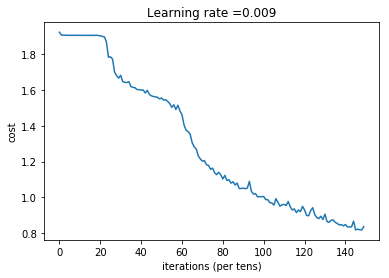

Instructions for updating:
Use `argmax` instead
corrent_prediction accuracy= Tensor("Mean_1:0", shape=(), dtype=float32)
训练集准确度：0.71666664
测试集准确度：0.59166664


In [72]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test,num_epochs=150)